In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import csv
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import tqdm         # make loops show as a smart progress meter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os

In [2]:
# 1) Classic_Model (ReLu,  bias, not orthogonal, Softmax)========================================================================================================
class ClassicalModel_Relu_Bias(nn.Module):
    def __init__(self, hidden_sizes, input_size=4, output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalModel_Relu_Bias, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [3]:
# 2) Classic_Model_NoBias (ReLU, no bias, Not orthogonal, SoftMax)============================================================================================
class ClassicalModel_ReLU_NoBias(nn.Module):
    def __init__(self, hidden_sizes,input_size=4, output_size=3):
        """
        ReLU, no bias, standard weights, SoftMax
        """
        super(ClassicalModel_ReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False)
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [4]:
# 3) Classic_Model_NoRelu (No ReLu, bias, Not orthogonal, SoftMax)========================================================================================================
class ClassicalModel_NoRelu_Bias(nn.Module):
    def __init__(self, hidden_sizes, input_size=4, output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalModel_NoRelu_Bias, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False)
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x): #defines how an input x becomes an output, passing through the network’s layers.
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            x = layer(x)
        # Apply softmax on the last layer (output)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [5]:
# 4) Classic_Model_NoReLU_NoBias (No ReLU, no bias, Not orthogonal, SoftMax)===============================================================================
class ClassicalModel_NoReLU_NoBias(nn.Module):
    def __init__(self, hidden_sizes, input_size=4, output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(ClassicalModel_NoReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False)
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [6]:
# 5) Classic_Model_Ortho_ReLU_Bias (ReLU, bias, orthogonal, SoftMax)======================================================================================
class ClassicalModel_Ortho_ReLU_Bias(nn.Module):
    def __init__(self, hidden_sizes,input_size=4, output_size=3):
        """
        ReLU, bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_ReLU_Bias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [7]:
# 6) Classic_Model_Ortho_ReLU_NoBias (ReLU, no bias, orthogonal, SoftMax)================================================================================
class ClassicalModel_Ortho_ReLU_NoBias(nn.Module):
    def __init__(self, hidden_sizes, input_size=4, output_size=3):
        """
        ReLU, no bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_ReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [8]:
# 7) Classic_Model_Ortho_NoReLU_Bias (No ReLU, bias, orthogonal, SoftMax)===============================================================================
class ClassicalModel_Ortho_NoReLU_Bias(nn.Module):
    def __init__(self, hidden_sizes, input_size=4, output_size=3):
        """
        No ReLU, bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_NoReLU_Bias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [9]:

# 8) Classic_Model_Ortho_NoReLU_NoBias (No ReLU, no bias, orthogonal, SoftMax)=========================================================================
class ClassicalModel_Ortho_NoReLU_NoBias(nn.Module):
    def __init__(self, hidden_sizes,input_size=4, output_size=3):
        """
        No ReLU, no bias, orthogonal weights, SoftMax
        """
        super(ClassicalModel_Ortho_NoReLU_NoBias, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]

        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1], bias=False))
            for i in range(len(layer_sizes)-1)
        ])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = F.softmax(self.layers[-1](x), dim=1)
        return x

In [10]:
# Real_Photonic_Model (Ortho, ReLu, SoftMax and bias)========================================================================================================
# Variable is added to the name because layers and neurons can now be chosen
class RealVariableModel(nn.Module):
    def __init__(self, hidden_sizes,input_size=4, output_size=3):
        """
        input_size: number of input features (e.g. 4 for Iris)
        hidden_sizes: list of hidden layer sizes, e.g. [8, 8, 4]
        output_size: number of output classes (e.g. 3 for Iris)
        """
        super(RealVariableModel, self).__init__()
        
        # Create a list of layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Create a list of Linear layers
        self.layers = nn.ModuleList([
            nn.utils.parametrizations.orthogonal(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, I_input):
        E = torch.sqrt(I_input).to(torch.complex64)
        # Go through all layers except the last one with ReLU
        for layer in self.layers[:-1]:
            E = F.relu(layer(E))
        # Apply softmax on the last layer (output)
        E = self.layers[-1](E)
        I_out = torch.real(E * E.conj())
        return F.softmax(I_out, dim=1)

In [11]:
class train_backprop():

    def __init__(self) -> None:
        iris = load_iris()
        X = iris['data']
        y = torch.tensor(iris['target'], dtype=torch.long)

        scaler = StandardScaler()
        X_scaled = torch.tensor(scaler.fit_transform(X), dtype=torch.float)

        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=2)  # Total n dat 150, so 120 for train and 30 for test

        self.train_data = TensorDataset(X_train, y_train)
        test_data = TensorDataset(X_test, y_test)

        self.train_loader = DataLoader(self.train_data, shuffle=True, batch_size=12)  # batch size 12 so 10 batch
        self.test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))  # batch size 30 max

    def train_IRIS(self, model, epochs: int = 400, epsilon: float = 0.02,
               log_first_layer=False, max_snapshots=10):

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        train_loss = np.zeros(epochs)
        valid_loss = np.zeros(epochs)
        train_accuracy = np.zeros(epochs)
        valid_accuracy = np.zeros(epochs)

        # 🔹 storage for matrices
        first_layer_matrices = []

        snapshot_count = 0

        for epoch in tqdm.trange(epochs):
            for X, y in self.train_loader:
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 🔹 log first-layer matrix
                if log_first_layer and snapshot_count < max_snapshots:
                    W = model.layers[0].weight.detach().cpu().numpy()
                    first_layer_matrices.append(W.copy())
                    snapshot_count += 1

            # --- metrics (unchanged) ---
            with torch.no_grad():
                X_train, y_train = self.train_data[:]
                y_pred_train = model(X_train)
                train_loss[epoch] = loss_fn(y_pred_train, y_train).item()
                y_pred_labels = torch.argmax(y_pred_train, axis=1)
                train_accuracy[epoch] = torch.mean((y_pred_labels == y_train).float()).item()

            with torch.no_grad():
                X_val, y_val = next(iter(self.test_loader))
                y_pred_val = model(X_val)
                valid_loss[epoch] = loss_fn(y_pred_val, y_val).item()
                y_pred_labels = torch.argmax(y_pred_val, axis=1)
                valid_accuracy[epoch] = torch.mean((y_pred_labels == y_val).float()).item()

        final_train_loss = train_loss[-1]
        final_valid_loss = valid_loss[-1]

        epochs_to_final_train = np.argmax(train_loss <= final_train_loss * (1 + epsilon)) + 1
        epochs_to_final_valid = np.argmax(valid_loss <= final_valid_loss * (1 + epsilon)) + 1

        return (train_loss, valid_loss, train_accuracy, valid_accuracy,
                epochs_to_final_train, epochs_to_final_valid,
                first_layer_matrices)

        

    def graph_train_IRIS(self, model, epochs: int = 400, n_runs: int = 15, epsilon: float = 0.02) -> None:
        """
        Train the given model multiple times (n_runs) and save all results in a single CSV file.
        For the FIRST run only, print the first 10 first-layer weight matrices
        (after optimizer steps) to verify orthogonality.
        """
        import os
        from datetime import datetime
        import pandas as pd
        import matplotlib.pyplot as plt

        os.makedirs("results", exist_ok=True)

        model_name = model.__class__.__name__

        # Detect hidden layer sizes
        try:
            hidden_sizes = [layer.out_features for layer in model.layers[:-1]]
        except AttributeError:
            hidden_sizes = ["Unknown"]

        global_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        all_runs = []

        for run in range(1, n_runs + 1):
            # ⚡ pass hidden_sizes explicitly
            model_instance = model.__class__(input_size=4, hidden_sizes=hidden_sizes, output_size=3)
            print(f"\n🚀 Run {run}/{n_runs} for {model_name} with layers {hidden_sizes}")

            optimizer = torch.optim.Adam(model_instance.parameters(), lr=0.001)
            loss_fn = nn.CrossEntropyLoss()

            train_loss = np.zeros(epochs)
            valid_loss = np.zeros(epochs)
            train_accuracy = np.zeros(epochs)
            valid_accuracy = np.zeros(epochs)

            printed = 0  # number of matrices printed so far

            for epoch in range(epochs):
                # --- TRAIN ---
                for X, y in self.train_loader:
                    y_pred = model_instance(X)
                    loss = loss_fn(y_pred, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # 🔹 PRINT FIRST 10 MATRICES (only run 1)
                    if run == 1 and printed < 10:
                        W = model_instance.layers[0].weight.detach().cpu().numpy()
                        print(f"\n--- First-layer weight matrix (step {printed + 1}) ---")
                        print(W)

                        # Orthogonality check
                        if W.shape[0] <= W.shape[1]:
                            M = W @ W.T
                            label = "W Wᵀ"
                        else:
                            M = W.T @ W
                            label = "Wᵀ W"

                        print(f"{label} (should be close to identity):")
                        print(M)

                        printed += 1

                # --- TRAIN METRICS ---
                with torch.no_grad():
                    X_train, y_train = self.train_data[:]
                    y_pred_train = model_instance(X_train)
                    train_loss[epoch] = loss_fn(y_pred_train, y_train).item()
                    train_accuracy[epoch] = (
                        torch.argmax(y_pred_train, dim=1) == y_train
                    ).float().mean().item()

                # --- VALIDATION METRICS ---
                with torch.no_grad():
                    X_val, y_val = next(iter(self.test_loader))
                    y_pred_val = model_instance(X_val)
                    valid_loss[epoch] = loss_fn(y_pred_val, y_val).item()
                    valid_accuracy[epoch] = (
                        torch.argmax(y_pred_val, dim=1) == y_val
                    ).float().mean().item()

            # --- FINAL METRICS ---
            final_train_loss = train_loss[-1]
            final_valid_loss = valid_loss[-1]
            final_train_acc = train_accuracy[-1]
            final_valid_acc = valid_accuracy[-1]

            epochs_to_final_train = np.argmax(train_loss <= final_train_loss * (1 + epsilon)) + 1
            epochs_to_final_valid = np.argmax(valid_loss <= final_valid_loss * (1 + epsilon)) + 1

            all_runs.append({
                "timestamp": global_timestamp,
                "model_name": model_name,
                "hidden_sizes": str(hidden_sizes),
                "epochs": epochs,
                "run_number": run,
                "final_train_loss": final_train_loss,
                "final_valid_loss": final_valid_loss,
                "final_train_accuracy": final_train_acc,
                "final_valid_accuracy": final_valid_acc,
                "epochs_to_final_train": epochs_to_final_train,
                "epochs_to_final_valid": epochs_to_final_valid
            })

            print(f"🏁 Validation accuracy (run {run}): {final_valid_acc:.3f}")
            print(f"⏱️ Epochs to converge (train/valid): {epochs_to_final_train}/{epochs_to_final_valid}")

            # --- PLOT ONLY FOR LAST RUN ---
            if run == n_runs:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

                ax1.plot(train_accuracy, label="Train accuracy")
                ax1.plot(valid_accuracy, label="Validation accuracy")
                ax1.set_title("Accuracy")
                ax1.set_xlabel("Epoch")
                ax1.set_ylim([0.0, 1.05])
                ax1.legend()

                ax2.plot(train_loss, label="Train loss")
                ax2.plot(valid_loss, label="Validation loss")
                ax2.set_title("Loss")
                ax2.set_xlabel("Epoch")
                ax2.legend()

                plt.tight_layout()
                plt.show()

        # --- SAVE RESULTS ---
        results_df = pd.DataFrame(all_runs)
        csv_filename = f"{model_name}_layers{hidden_sizes}_epochs{epochs}_{n_runs}runs_{global_timestamp}.csv"
        csv_path = os.path.join("results", csv_filename)
        results_df.to_csv(csv_path, index=False)

        print(f"\n✅ All {n_runs} runs saved in one file → {csv_path}")
    # ======================================================    




🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [1]

--- First-layer weight matrix (step 1) ---
[[ 0.13005932 -0.36626405  0.18464042  0.4243154 ]]
W Wᵀ (should be close to identity):
[[0.36520043]]

--- First-layer weight matrix (step 2) ---
[[ 0.13105653 -0.36722344  0.18563747  0.42531055]]
W Wᵀ (should be close to identity):
[[0.36737922]]

--- First-layer weight matrix (step 3) ---
[[ 0.13204594 -0.36801556  0.1866132   0.4262853 ]]
W Wᵀ (should be close to identity):
[[0.36941522]]

--- First-layer weight matrix (step 4) ---
[[ 0.13304162 -0.368873    0.18758109  0.42725852]]
W Wᵀ (should be close to identity):
[[0.3715039]]

--- First-layer weight matrix (step 5) ---
[[ 0.13403122 -0.36977077  0.18854035  0.428218  ]]
W Wᵀ (should be close to identity):
[[0.3736129]]

--- First-layer weight matrix (step 6) ---
[[ 0.1349634  -0.37064096  0.18947192  0.42915776]]
W Wᵀ (should be close to identity):
[[0.37566584]]

--- First-layer weight matrix (step 7) ---
[[ 0.13580862 -0.37

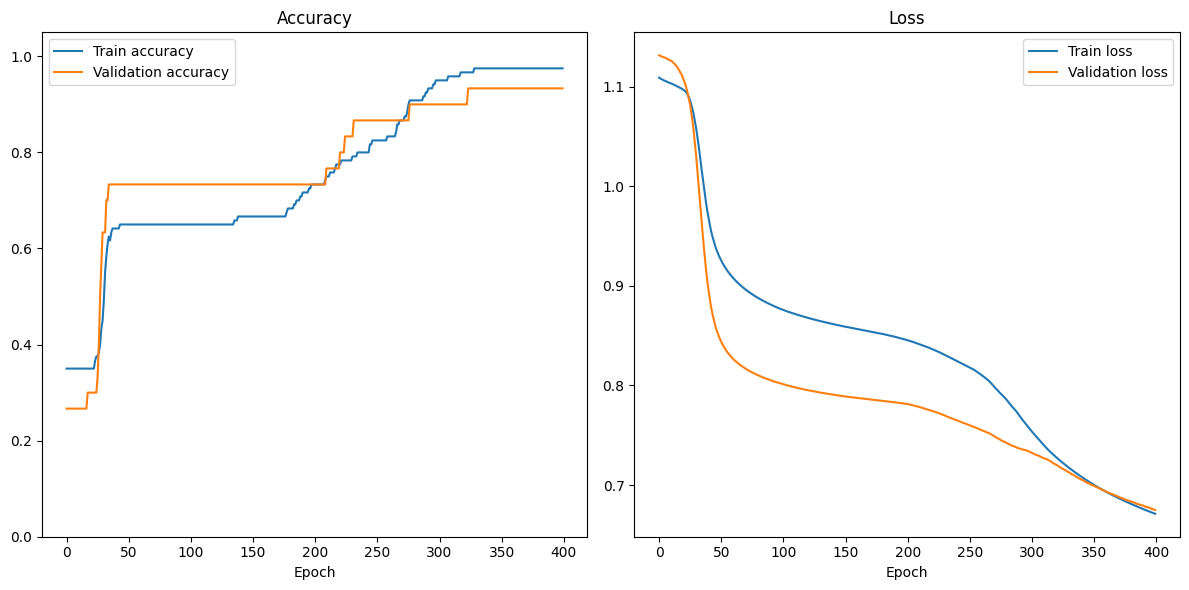


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[1]_epochs400_15runs_20260103_110932.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [1, 1]

--- First-layer weight matrix (step 1) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]
W Wᵀ (should be close to identity):
[[0.1654776]]

--- First-layer weight matrix (step 2) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]
W Wᵀ (should be close to identity):
[[0.1654776]]

--- First-layer weight matrix (step 3) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]
W Wᵀ (should be close to identity):
[[0.1654776]]

--- First-layer weight matrix (step 4) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]
W Wᵀ (should be close to identity):
[[0.1654776]]

--- First-layer weight matrix (step 5) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]
W Wᵀ (should be close to identity):
[[0.1654776]]

--- First-layer weight matrix (step 6) ---
[[-0.3758734   0.10130459 -0.09252614  0.07330137]]

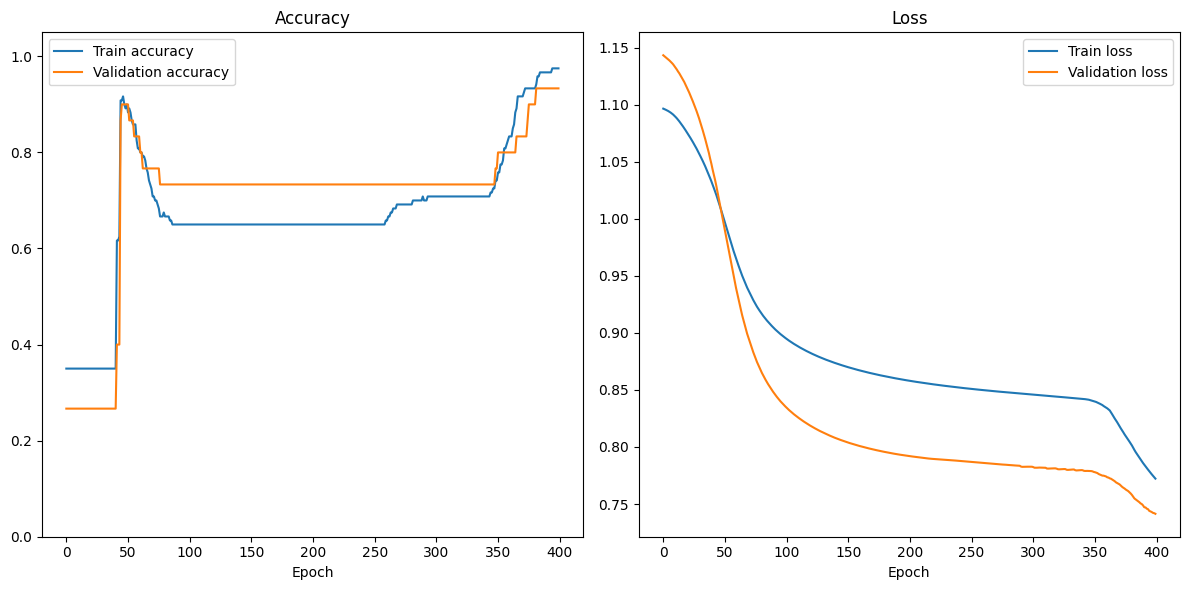


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[1, 1]_epochs400_15runs_20260103_111102.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [1, 1, 1]

--- First-layer weight matrix (step 1) ---
[[-0.13389006 -0.17984338 -0.21571736 -0.37542257]]
W Wᵀ (should be close to identity):
[[0.23774627]]

--- First-layer weight matrix (step 2) ---
[[-0.13473381 -0.1788938  -0.21665354 -0.37639132]]
W Wᵀ (should be close to identity):
[[0.23876537]]

--- First-layer weight matrix (step 3) ---
[[-0.13557807 -0.17805001 -0.21756564 -0.37732774]]
W Wᵀ (should be close to identity):
[[0.23979425]]

--- First-layer weight matrix (step 4) ---
[[-0.13641223 -0.1772405  -0.21843503 -0.37820527]]
W Wᵀ (should be close to identity):
[[0.24077559]]

--- First-layer weight matrix (step 5) ---
[[-0.13720672 -0.1763984  -0.21927673 -0.37906525]]
W Wᵀ (should be close to identity):
[[0.24171482]]

--- First-layer weight matrix (step 6) ---
[[-0.13792847 -0.17562063 -0.22003958 -0

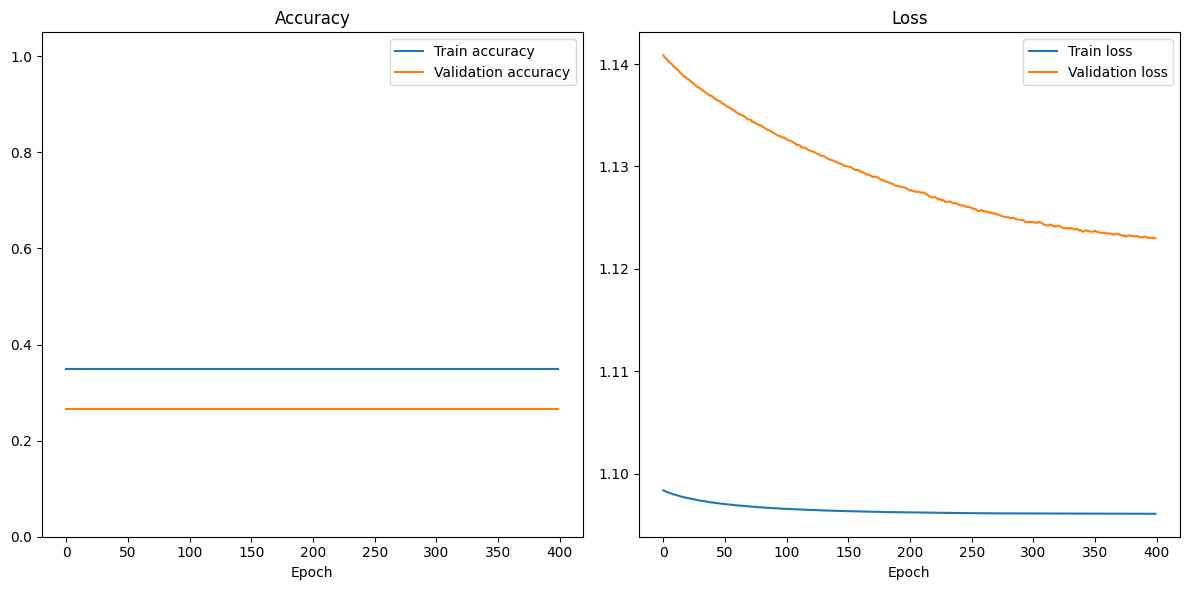


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[1, 1, 1]_epochs400_15runs_20260103_111321.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [1, 1, 1, 1]

--- First-layer weight matrix (step 1) ---
[[ 0.49597776 -0.46234083 -0.1992547  -0.4020896 ]]
W Wᵀ (should be close to identity):
[[0.6611315]]

--- First-layer weight matrix (step 2) ---
[[ 0.49499157 -0.46134245 -0.2002557  -0.4030895 ]]
W Wᵀ (should be close to identity):
[[0.660437]]

--- First-layer weight matrix (step 3) ---
[[ 0.49399775 -0.46037558 -0.2012591  -0.40408495]]
W Wᵀ (should be close to identity):
[[0.6597693]]

--- First-layer weight matrix (step 4) ---
[[ 0.4929982  -0.45939994 -0.20226571 -0.40508538]]
W Wᵀ (should be close to identity):
[[0.6591011]]

--- First-layer weight matrix (step 5) ---
[[ 0.49209702 -0.45841256 -0.20324306 -0.4060633 ]]
W Wᵀ (should be close to identity):
[[0.6584967]]

--- First-layer weight matrix (step 6) ---
[[ 0.49116623 -0.457448   -0.20423095 -0

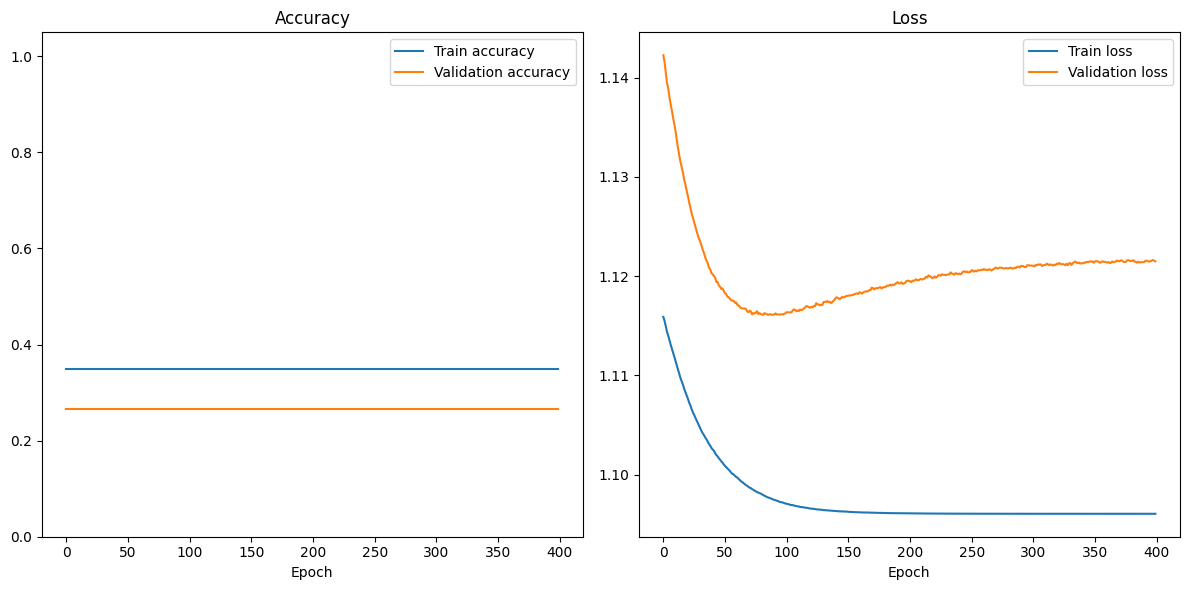


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[1, 1, 1, 1]_epochs400_15runs_20260103_111534.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [2]

--- First-layer weight matrix (step 1) ---
[[ 0.37959558  0.05011575 -0.35045493  0.39414877]
 [-0.040046    0.2882138  -0.00813807  0.44839776]]
W Wᵀ (should be close to identity):
[[0.4247763  0.17883022]
 [0.17883022 0.28579766]]

--- First-layer weight matrix (step 2) ---
[[ 0.37885866  0.04918591 -0.35067597  0.39327577]
 [-0.04073043  0.28920946 -0.00912922  0.44739643]]
W Wᵀ (should be close to identity):
[[0.4235926  0.17794552]
 [0.17794552 0.28554797]]

--- First-layer weight matrix (step 3) ---
[[ 0.37806728  0.04822559 -0.35130832  0.39237073]
 [-0.0402883   0.29020888 -0.00970004  0.447053  ]]
W Wᵀ (should be close to identity):
[[0.42263293 0.17758201]
 [0.17758201 0.2857948 ]]

--- First-layer weight matrix (step 4) ---
[[ 0.37720135  0.04733378 -0.352084    0.39142936]
 [-0.03974109  0.29111

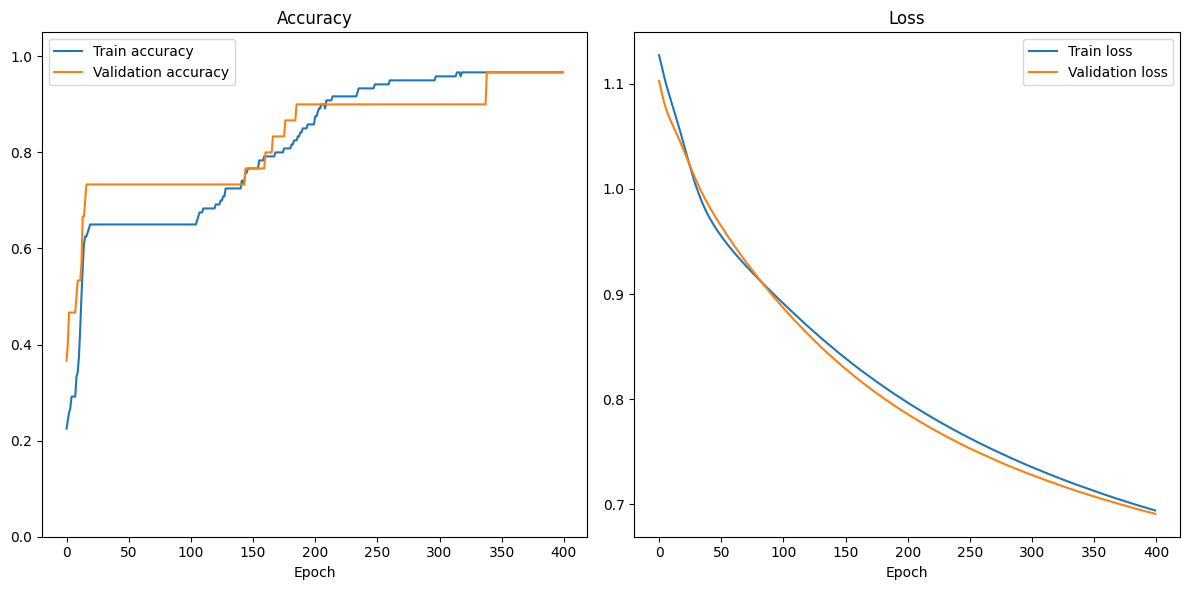


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[2]_epochs400_15runs_20260103_111807.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [2, 2]

--- First-layer weight matrix (step 1) ---
[[ 0.14705716  0.40186787  0.27677393  0.38932282]
 [-0.03247232  0.4479714   0.20266108 -0.357224  ]]
W Wᵀ (should be close to identity):
[[0.41129965 0.09226588]
 [0.09226588 0.37041333]]

--- First-layer weight matrix (step 2) ---
[[ 0.14607425  0.40087882  0.27578372  0.38832602]
 [-0.03346114  0.4489225   0.20166127 -0.3582234 ]]
W Wᵀ (should be close to identity):
[[0.40889525 0.09158313]
 [0.09158313 0.37164232]]

--- First-layer weight matrix (step 3) ---
[[ 0.14509167  0.40031007  0.27484608  0.3874484 ]
 [-0.03444349  0.44979742  0.20066197 -0.35922438]]
W Wᵀ (should be close to identity):
[[0.40695637 0.09103121]
 [0.09103121 0.37281147]]

--- First-layer weight matrix (step 4) ---
[[ 0.14412685  0.3998783   0.2739635   0.38663754]
 [-0.03541927  0.45065582  0

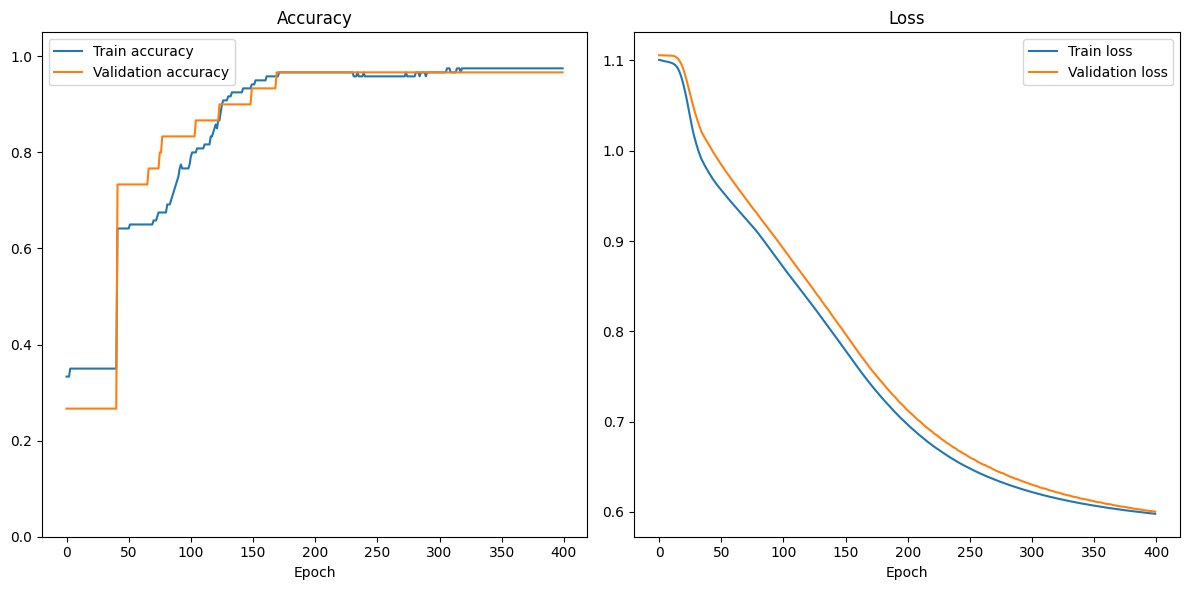


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[2, 2]_epochs400_15runs_20260103_111940.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [2, 2, 2]

--- First-layer weight matrix (step 1) ---
[[-0.4906962  -0.42438716  0.02935815  0.42822236]
 [ 0.2067035  -0.48473132 -0.08874548  0.05274535]]
W Wᵀ (should be close to identity):
[[0.6051235  0.12426646]
 [0.12426646 0.28834864]]

--- First-layer weight matrix (step 2) ---
[[-0.49002615 -0.4237171   0.03002819  0.4288924 ]
 [ 0.20737356 -0.48406127 -0.08807544  0.0534154 ]]
W Wᵀ (should be close to identity):
[[0.6045122  0.12375128]
 [0.12375128 0.2879296 ]]

--- First-layer weight matrix (step 3) ---
[[-0.48997524 -0.42381185  0.03074481  0.42966014]
 [ 0.2074244  -0.48415604 -0.08735884  0.05418311]]
W Wᵀ (should be close to identity):
[[0.6052453  0.12415274]
 [0.12415274 0.28799933]]

--- First-layer weight matrix (step 4) ---
[[-0.48993355 -0.42388946  0.03133181  0.430289  ]
 [ 0.20746605 -0.48423

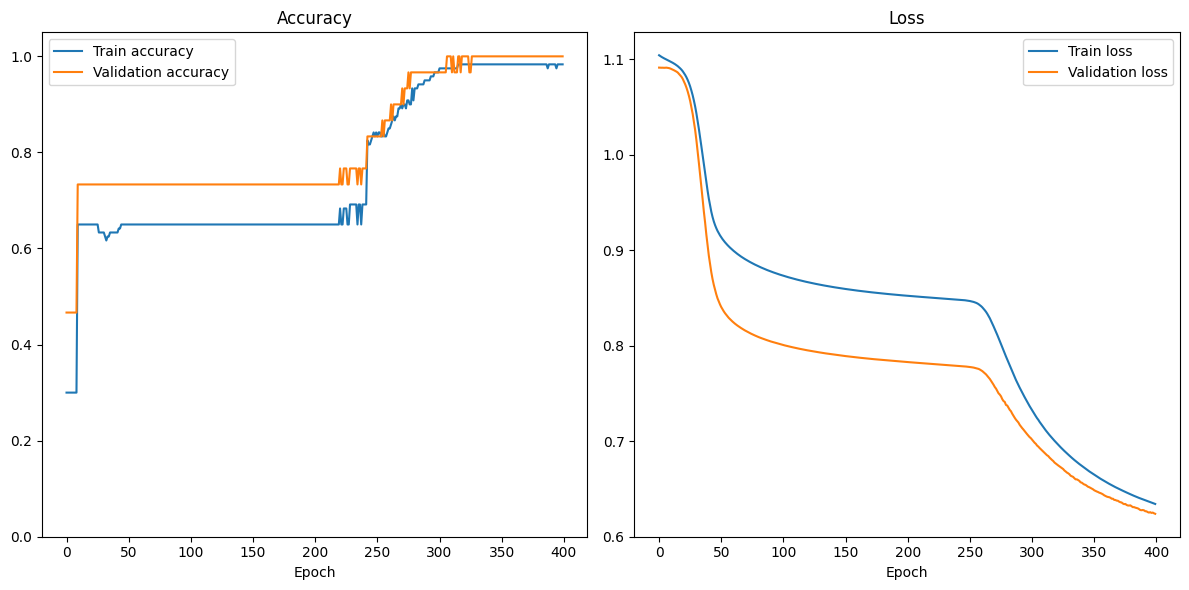


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[2, 2, 2]_epochs400_15runs_20260103_112133.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [2, 2, 2, 2]

--- First-layer weight matrix (step 1) ---
[[-0.02332605 -0.42961252 -0.40889466  0.25310355]
 [ 0.05347812  0.21335341  0.23396504  0.20444055]]
W Wᵀ (should be close to identity):
[[ 0.41636726 -0.13682915]
 [-0.13682915  0.14491516]]

--- First-layer weight matrix (step 2) ---
[[-0.02384432 -0.4288013  -0.4095711   0.25397348]
 [ 0.05442708  0.2141529   0.23481898  0.20528813]]
W Wᵀ (should be close to identity):
[[ 0.41669014 -0.13716415]
 [-0.13716415  0.14610694]]

--- First-layer weight matrix (step 3) ---
[[-0.0240711  -0.4280986  -0.4097325   0.2548812 ]
 [ 0.05535216  0.21467009  0.23566274  0.20619833]]
W Wᵀ (should be close to identity):
[[ 0.41669294 -0.13723496]
 [-0.13723496  0.14720179]]

--- First-layer weight matrix (step 4) ---
[[-0.02399527 -0.42742872 -0.40959215  0.25574547]
 [ 0

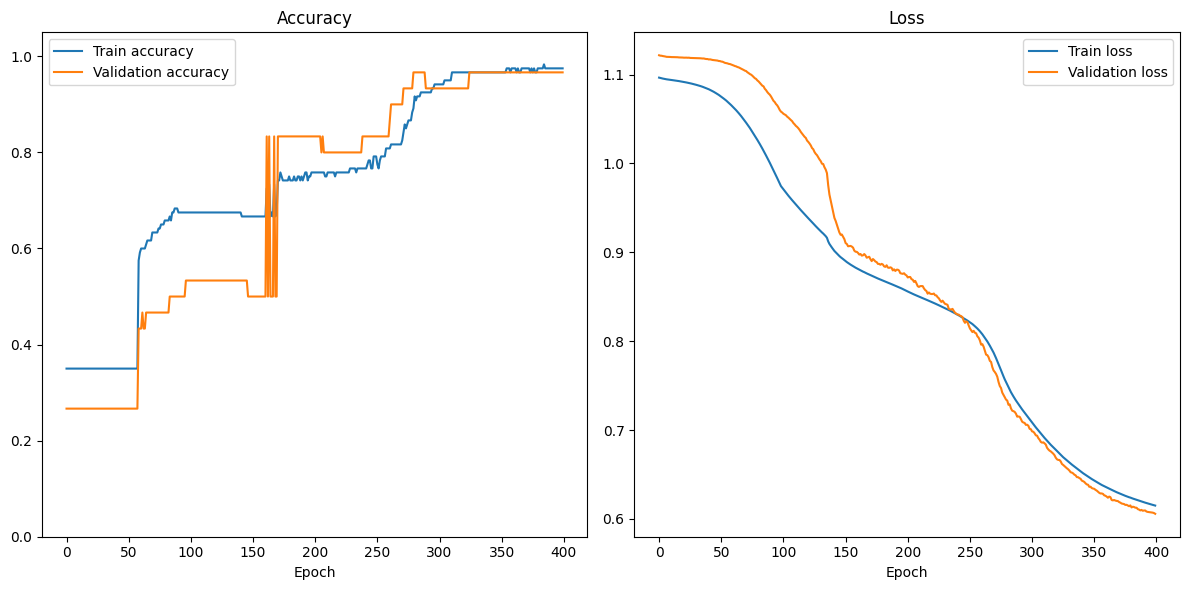


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[2, 2, 2, 2]_epochs400_15runs_20260103_112342.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [3]

--- First-layer weight matrix (step 1) ---
[[ 0.04366504 -0.15242432 -0.20829399  0.29402536]
 [-0.45301694  0.36053354  0.35788953 -0.36230385]
 [ 0.46980935  0.22272182  0.44200456 -0.37922287]]
W Wᵀ (should be close to identity):
[[ 0.15497711 -0.25580785 -0.217002  ]
 [-0.25580785  0.59455776  0.16304979]
 [-0.217002    0.16304979  0.60950387]]

--- First-layer weight matrix (step 2) ---
[[ 0.04267081 -0.15148674 -0.20928727  0.29304415]
 [-0.45400503  0.36138675  0.3569194  -0.36328134]
 [ 0.46883783  0.22172652  0.44102666 -0.38017464]]
W Wᵀ (should be close to identity):
[[ 0.15444507 -0.2552742  -0.21729216]
 [-0.2552742   0.5960857   0.16279562]
 [-0.21729216  0.16279562  0.6080088 ]]

--- First-layer weight matrix (step 3) ---
[[ 0.04169556 -0.15071611 -0.21027881  0.29206055]
 [-0.4549987   0.362

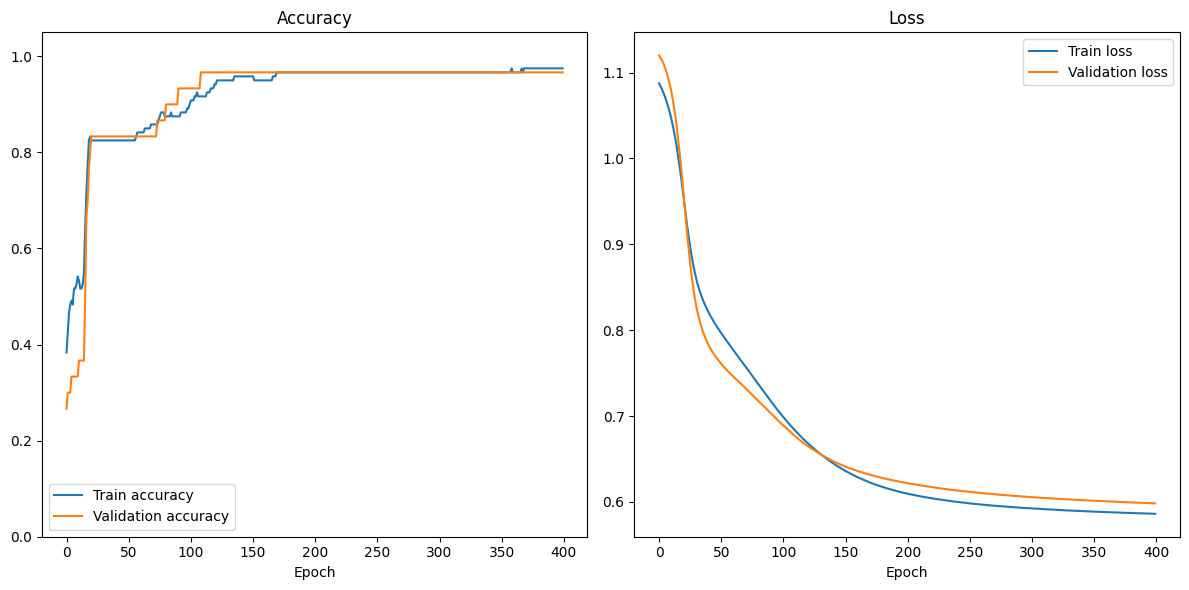


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[3]_epochs400_15runs_20260103_112608.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [3, 3]

--- First-layer weight matrix (step 1) ---
[[ 0.44734794  0.1392346   0.05542959 -0.00565212]
 [-0.3406822   0.08926611  0.3705275  -0.498235  ]
 [-0.03969997 -0.02049727 -0.03027039  0.15265156]]
W Wᵀ (should be close to identity):
[[ 0.22261085 -0.11662029 -0.02315431]
 [-0.11662029  0.50956154 -0.075577  ]
 [-0.02315431 -0.075577    0.02621502]]

--- First-layer weight matrix (step 2) ---
[[ 0.4483047   0.1401518   0.05637901 -0.00466185]
 [-0.34086505  0.08850963  0.37147614 -0.49732992]
 [-0.03870149 -0.0209654  -0.02927746  0.15364607]]
W Wᵀ (should be close to identity):
[[ 0.22381997 -0.11714469 -0.02265531]
 [-0.11714469  0.50935453 -0.07595232]
 [-0.02265531 -0.07595232  0.02640164]]

--- First-layer weight matrix (step 3) ---
[[ 0.44913587  0.14053692  0.05724606 -0.00372311]
 [-0.34058225  0.0877225  

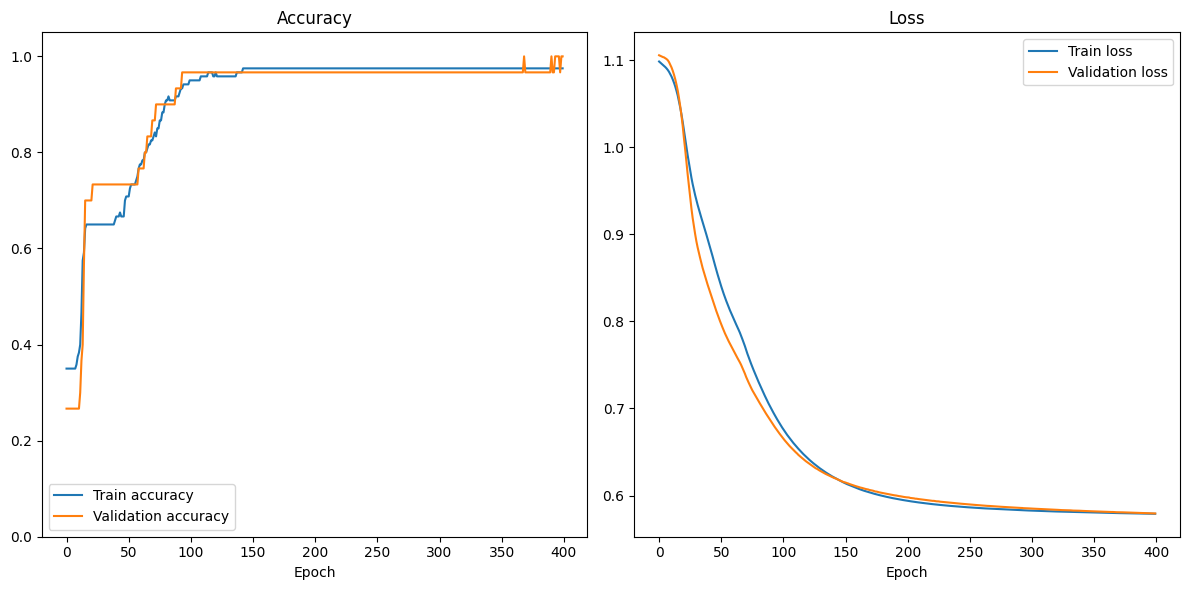


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[3, 3]_epochs400_15runs_20260103_112750.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [3, 3, 3]

--- First-layer weight matrix (step 1) ---
[[ 0.07280864 -0.3611492  -0.04537683  0.45090544]
 [-0.00846989  0.32526553  0.3340373   0.17660813]
 [-0.44313776 -0.20721434 -0.13598037  0.32212985]]
W Wᵀ (should be close to identity):
[[ 0.3411046  -0.05361005  0.1939915 ]
 [-0.05361005  0.24864075 -0.05217812]
 [ 0.1939915  -0.05217812  0.36156717]]

--- First-layer weight matrix (step 2) ---
[[ 0.07359675 -0.36015478 -0.04460879  0.45182207]
 [-0.00938567  0.3243771   0.33313987  0.17566098]
 [-0.44367245 -0.20627122 -0.13669682  0.32152075]]
W Wᵀ (should be close to identity):
[[ 0.3412611  -0.05301017  0.19300476]
 [-0.05301017  0.24714755 -0.051806  ]
 [ 0.19300476 -0.051806    0.36145467]]

--- First-layer weight matrix (step 3) ---
[[ 0.07439739 -0.3591863  -0.04407528  0.4525526 ]
 [-0.01033728  0.323

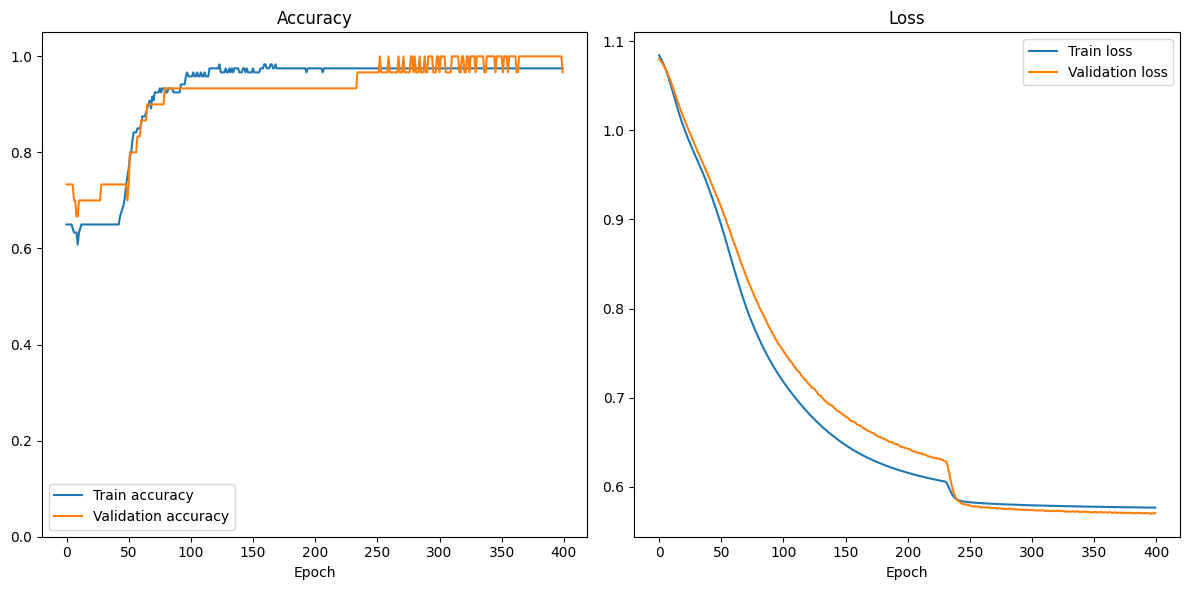


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[3, 3, 3]_epochs400_15runs_20260103_112949.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [3, 3, 3, 3]

--- First-layer weight matrix (step 1) ---
[[ 0.35479227 -0.08162072 -0.34851244 -0.26003733]
 [-0.17075859  0.2525698  -0.4441123   0.19212788]
 [ 0.2535935  -0.02735823 -0.0623433   0.16713965]]
W Wᵀ (should be close to identity):
[[0.32161984 0.02361948 0.07047088]
 [0.02361948 0.32709885 0.00958648]
 [0.07047088 0.00958648 0.09688048]]

--- First-layer weight matrix (step 2) ---
[[ 0.3556953  -0.08185691 -0.34755152 -0.25907406]
 [-0.16983846  0.25163302 -0.44311818  0.1931239 ]
 [ 0.25272846 -0.02637058 -0.0632147   0.16628173]]
W Wᵀ (should be close to identity):
[[0.32113114 0.02296436 0.07094401]
 [0.02296436 0.32581484 0.01056584]
 [0.07094401 0.01056584 0.09621279]]

--- First-layer weight matrix (step 3) ---
[[ 0.35661456 -0.08251605 -0.34657702 -0.25809792]
 [-0.1692171   0.2506967  -0.442

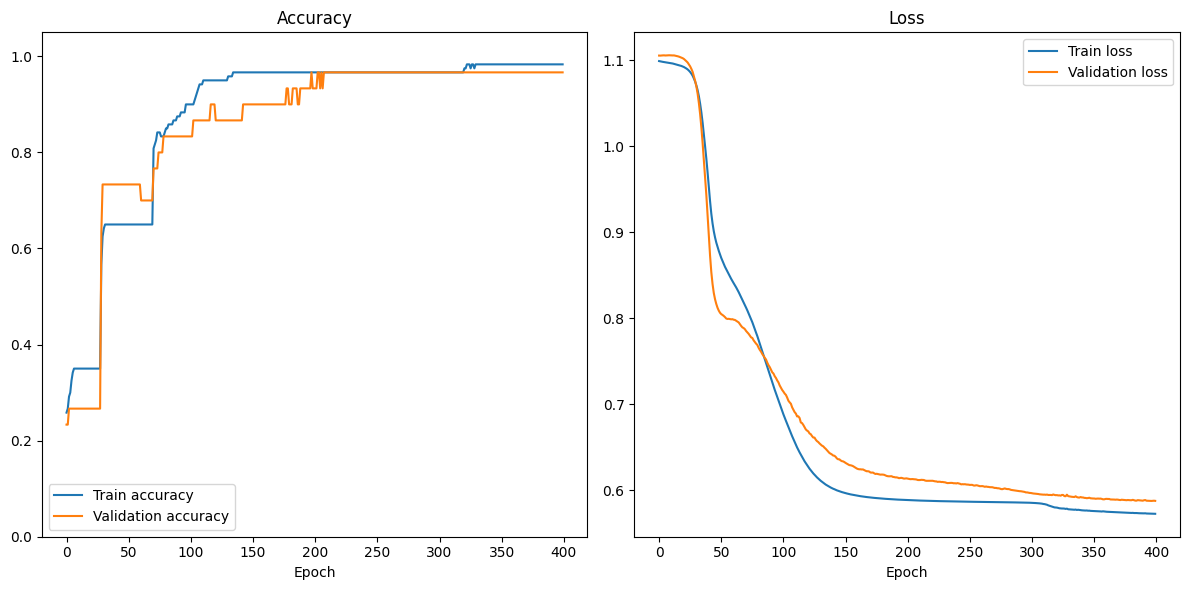


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[3, 3, 3, 3]_epochs400_15runs_20260103_113209.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [4]

--- First-layer weight matrix (step 1) ---
[[ 0.04807179  0.3993774   0.3062417   0.41607445]
 [-0.42772728  0.10269827  0.10786897  0.21545458]
 [-0.09659415 -0.39559644 -0.35953373  0.3055433 ]
 [ 0.48786056  0.05350988 -0.459696   -0.01173292]]
W Wᵀ (should be close to identity):
[[ 0.42871514  0.14313287 -0.14561118 -0.10083688]
 [ 0.14313287  0.25155395  0.02773705 -0.25529075]
 [-0.14561118  0.02773705  0.38844818  0.0933985 ]
 [-0.10083688 -0.25529075  0.0933985   0.4523293 ]]

--- First-layer weight matrix (step 2) ---
[[ 0.04713309  0.39887413  0.30525923  0.41513318]
 [-0.42847142  0.10195413  0.1086131   0.21619871]
 [-0.09560157 -0.3947156  -0.35930428  0.30635753]
 [ 0.4888611   0.05294975 -0.4587219  -0.01073442]]
W Wᵀ (should be close to identity):
[[ 0.42684087  0.1433781  -0.14444962 -0.100

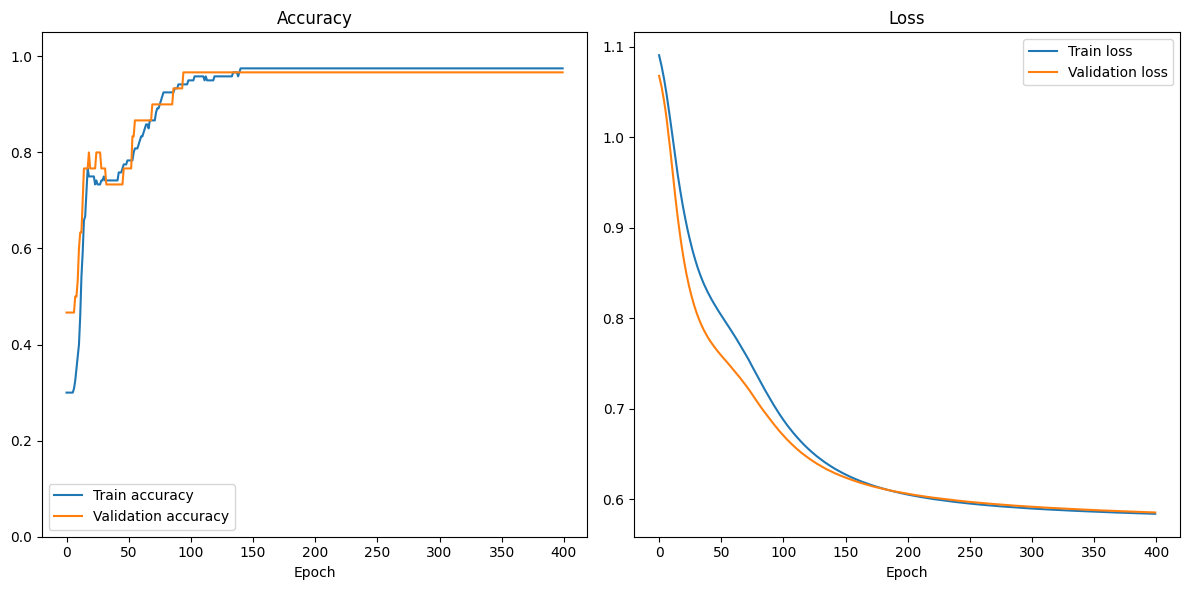


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[4]_epochs400_15runs_20260103_113448.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [4, 4]

--- First-layer weight matrix (step 1) ---
[[-0.09613807  0.3058011   0.28671277  0.17944627]
 [-0.41128373  0.3121785  -0.06134306 -0.13971882]
 [ 0.28847927  0.3094809  -0.43769538 -0.39480966]
 [ 0.32181203  0.37305975  0.03603416  0.21925949]]
W Wᵀ (should be close to identity):
[[ 0.21716201  0.09234469 -0.12943421  0.13282044]
 [ 0.09234469  0.289894    0.05997837 -0.04873994]
 [-0.12943421  0.05997837  0.52645063  0.10595322]
 [ 0.13282044 -0.04873994  0.10595322  0.29210973]]

--- First-layer weight matrix (step 2) ---
[[-0.09712233  0.30680192  0.2857227   0.17845376]
 [-0.41031808  0.31119832 -0.06037583 -0.13873447]
 [ 0.28748903  0.31044772 -0.43868333 -0.39580688]
 [ 0.32082194  0.37236783  0.03511349  0.21836749]]
W Wᵀ (should be close to identity):
[[ 0.21704337  0.09331886 -0.12865065  0.13208541]

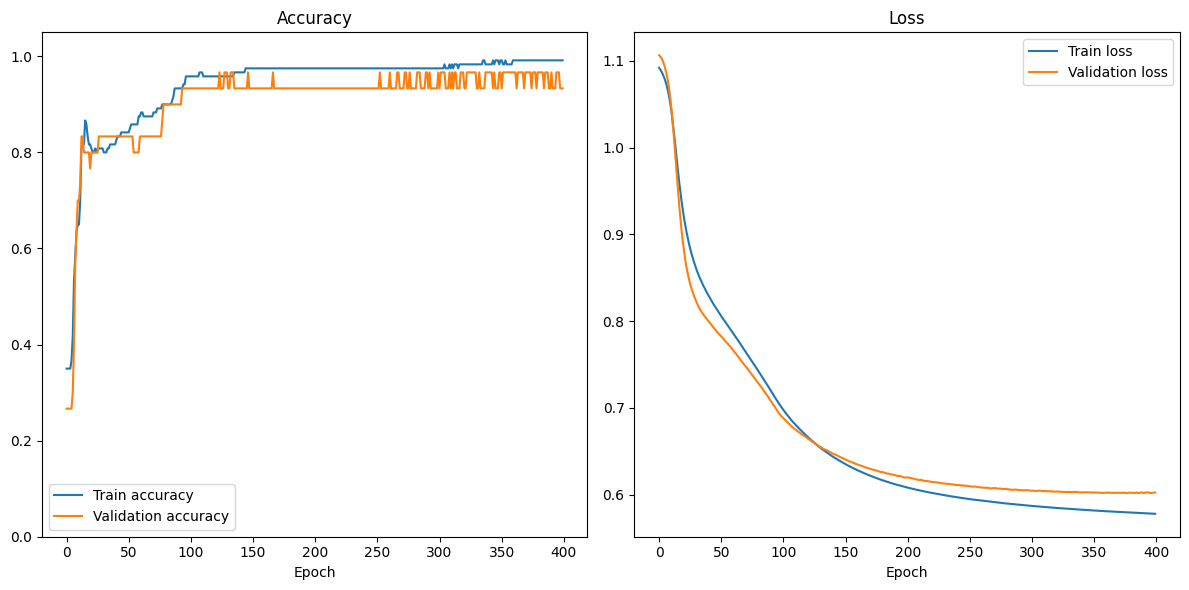


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[4, 4]_epochs400_15runs_20260103_113629.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [4, 4, 4]

--- First-layer weight matrix (step 1) ---
[[-0.02275842  0.2601506   0.20059705  0.1680839 ]
 [ 0.3496313   0.1544778   0.12107747 -0.3341847 ]
 [-0.3898064  -0.09459298  0.49762243  0.11426663]
 [ 0.0866684   0.13183957  0.3527254  -0.13571185]]
W Wᵀ (should be close to identity):
[[ 1.3668767e-01  3.4714860e-04  1.0329093e-01  8.0270402e-02]
 [ 3.4714860e-04  2.7244461e-01 -1.2883633e-01  1.3872820e-01]
 [ 1.0329093e-01 -1.2883633e-01  4.2158180e-01  1.1376173e-01]
 [ 8.0270402e-02  1.3872820e-01  1.1376173e-01  1.6772598e-01]]

--- First-layer weight matrix (step 2) ---
[[-0.02311408  0.25915205  0.19959848  0.16729565]
 [ 0.34950852  0.15532365  0.12035655 -0.33508527]
 [-0.38910607 -0.09359942  0.49689683  0.11360707]
 [ 0.08766644  0.13253602  0.35350728 -0.13500041]]
W Wᵀ (should be close to identit

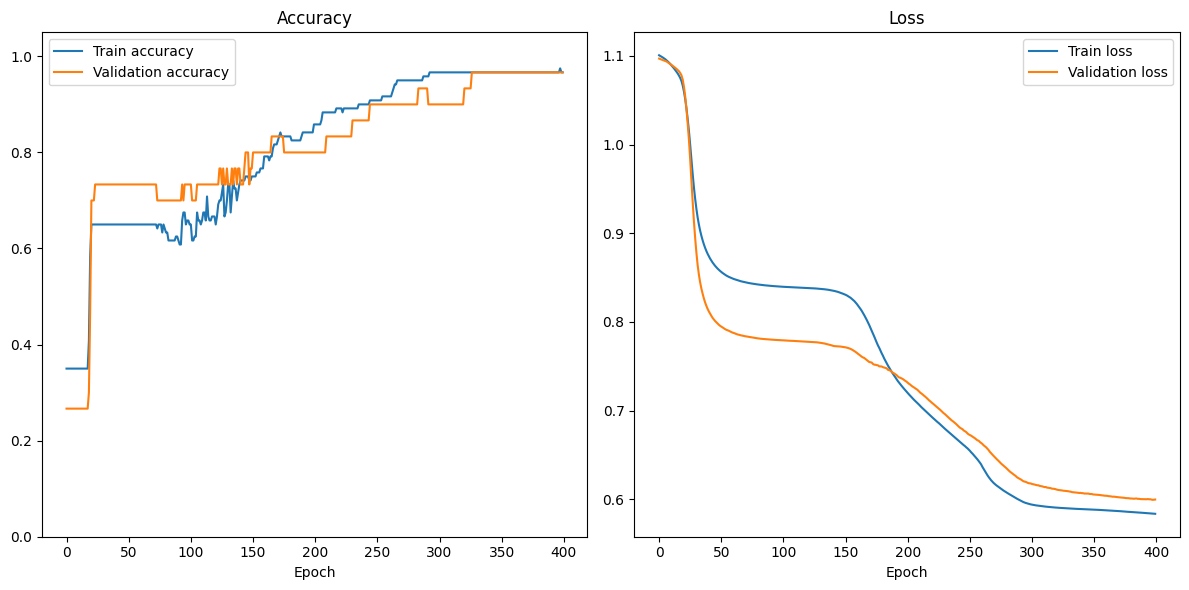


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[4, 4, 4]_epochs400_15runs_20260103_113824.csv

🚀 Run 1/15 for ClassicalModel_Relu_Bias with layers [4, 4, 4, 4]

--- First-layer weight matrix (step 1) ---
[[ 0.3976786  -0.20351338 -0.28465343  0.09462672]
 [-0.3126474  -0.18724644 -0.3494891  -0.45497006]
 [-0.39896744 -0.06132203  0.06580997 -0.29187548]
 [ 0.16783851  0.02127963  0.32447726 -0.12720656]]
W Wᵀ (should be close to identity):
[[ 0.28954777 -0.02979509 -0.19253321 -0.0419856 ]
 [-0.02979509  0.46195     0.24601321 -0.1119849 ]
 [-0.19253321  0.24601321  0.25245768 -0.0097847 ]
 [-0.0419856  -0.1119849  -0.0097847   0.15008959]]

--- First-layer weight matrix (step 2) ---
[[ 0.3976786  -0.20351338 -0.28465343  0.09462672]
 [-0.3126474  -0.18724644 -0.3494891  -0.45497006]
 [-0.39896744 -0.06132203  0.06580997 -0.29187548]
 [ 0.16783851  0.02127963  0.32447726 -0.12720656]]
W Wᵀ (should be close to identity):
[[ 0.28954777 -0.02979509 -0.19253321 

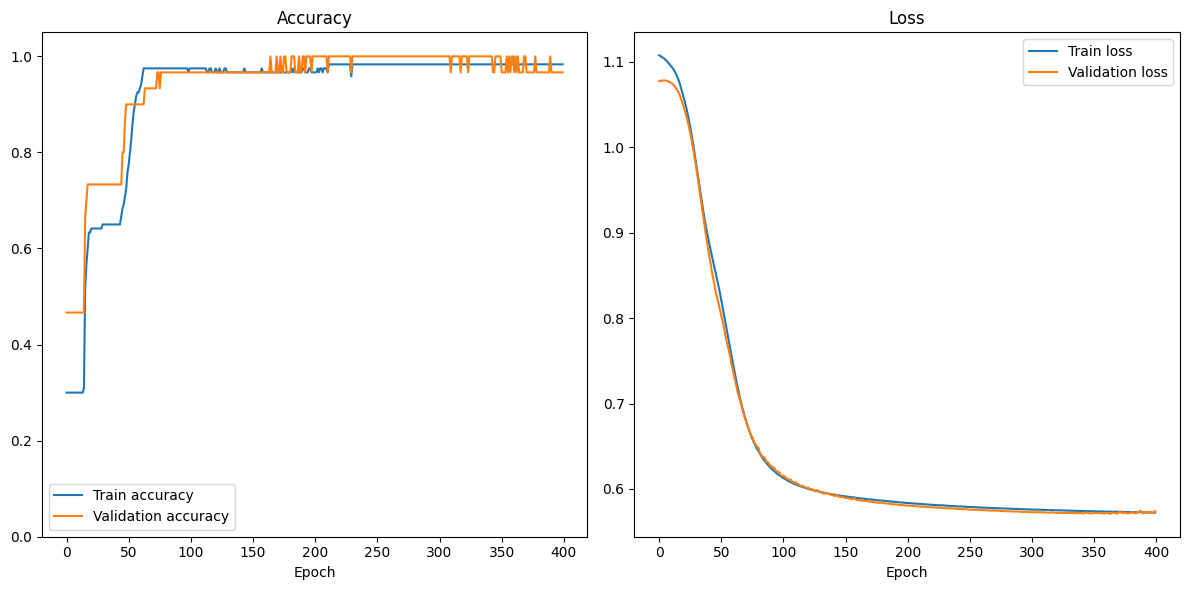


✅ All 15 runs saved in one file → results\ClassicalModel_Relu_Bias_layers[4, 4, 4, 4]_epochs400_15runs_20260103_114029.csv


In [ ]:
a = train_backprop()

for n in range(1, 5):  # neurons per layer 1 → 4
    for layers in range(1, 5):  # number of layers 1 → 4

        hidden_config = [n] * layers  # e.g. [3,3,3]

        # run training + save CSV
        a.graph_train_IRIS(ClassicalModel_Ortho_ReLU_Bias(hidden_sizes=hidden_config))
